In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
!cp /content/drive/MyDrive/The\ School\ of\ AI/ERAV3/ERAv3_Session7_Assignment_v1/model_v6.py /content
!cp /content/drive/MyDrive/The\ School\ of\ AI/ERAV3/ERAv3_Session7_Assignment_v1/utils_v2.py /content

In [4]:
import model_v6
import utils_v2
from model_v6 import Net
from utils_v2 import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CUDA Available? False
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CUDA Available? False


In [5]:
# Train data transformations
train_transforms = transforms.Compose([
    #transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-7.0, 7.0), fill=(1,)), # do it in later attempt
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [6]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
#test_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms) --> Commented the incorrect line. train = False and test_transform needs to be passed
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.36MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [7]:
type(train_data), len(train_data), len(train_data[0]), train_data.data.shape, test_data.data.shape

(torchvision.datasets.mnist.MNIST,
 60000,
 2,
 torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]))

In [8]:
SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

batch_size = 128

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

#kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True} --> Commented the incorrect line. shuffle parameter needs to be True
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

#test_loader = torch.utils.data.DataLoader(train_data, **kwargs) --> Commented the incorrect line. test_data needs be passed for test_loader
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CUDA Available? False


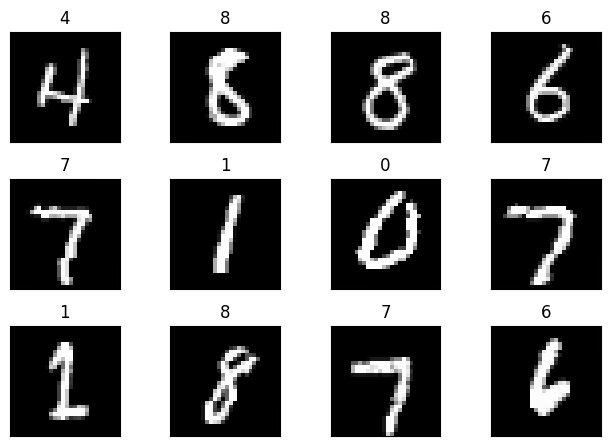

In [9]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [10]:
from tqdm import tqdm

In [ ]:
# Data to plot accuracy and loss graphs
#train_losses = []
#test_losses = []
#train_acc = []
#test_acc = []

#test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [12]:
!pip install torchsummary
from torchsummary import summary

In [13]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,152
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14           [-1, 10,

In [14]:
import torch.optim.lr_scheduler as lrs

In [15]:
model = Net().to(device)
#optimizer = optim.SGD(model.parameters(), lr=10.01, momentum=0.9) -- Commented the line since learning rate needs to be corrected
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = lrs.ReduceLROnPlateau(optimizer, 'min',patience = 3, verbose=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1, verbose=True)

# New Line
criterion = nn.CrossEntropyLoss()
#criterion = F.nll_loss()
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  #test(model, device, train_loader) --> Removed this incorrect line. test_loader needs to be passed here
  test_loss = test(model, device, test_loader, criterion)
  scheduler.step()
  #scheduler.step(test_loss)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1


Train: Loss=0.1366 Batch_id=468 Accuracy=87.59: 100%|██████████| 469/469 [01:00<00:00,  7.74it/s]


Test set: Average loss: 0.0736, Accuracy: 9803/10000 (98.03%)

Epoch 2


Train: Loss=0.0635 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:55<00:00,  8.46it/s]


Test set: Average loss: 0.0470, Accuracy: 9872/10000 (98.72%)

Epoch 3


Train: Loss=0.0251 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:56<00:00,  8.26it/s]


Test set: Average loss: 0.0404, Accuracy: 9879/10000 (98.79%)

Epoch 4


Train: Loss=0.0106 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:54<00:00,  8.53it/s]


Test set: Average loss: 0.0361, Accuracy: 9889/10000 (98.89%)

Epoch 5


Train: Loss=0.0713 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:54<00:00,  8.65it/s]


Test set: Average loss: 0.0351, Accuracy: 9892/10000 (98.92%)

Epoch 6


Train: Loss=0.0145 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


Test set: Average loss: 0.0321, Accuracy: 9898/10000 (98.98%)

Epoch 7


Train: Loss=0.0384 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:55<00:00,  8.46it/s]


Test set: Average loss: 0.0227, Accuracy: 9934/10000 (99.34%)

Epoch 8


Train: Loss=0.0291 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:55<00:00,  8.52it/s]


Test set: Average loss: 0.0222, Accuracy: 9931/10000 (99.31%)

Epoch 9


Train: Loss=0.0111 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:55<00:00,  8.46it/s]


Test set: Average loss: 0.0213, Accuracy: 9935/10000 (99.35%)

Epoch 10


Train: Loss=0.0336 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:55<00:00,  8.47it/s]


Test set: Average loss: 0.0219, Accuracy: 9935/10000 (99.35%)

Epoch 11


Train: Loss=0.0449 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:54<00:00,  8.65it/s]


Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)

Epoch 12


Train: Loss=0.0130 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:56<00:00,  8.37it/s]


Test set: Average loss: 0.0207, Accuracy: 9938/10000 (99.38%)

Epoch 13


Train: Loss=0.0108 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:57<00:00,  8.18it/s]


Test set: Average loss: 0.0206, Accuracy: 9942/10000 (99.42%)

Epoch 14


Train: Loss=0.0107 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:55<00:00,  8.41it/s]


Test set: Average loss: 0.0212, Accuracy: 9936/10000 (99.36%)

Epoch 15


Train: Loss=0.0497 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:53<00:00,  8.72it/s]


Test set: Average loss: 0.0206, Accuracy: 9941/10000 (99.41%)



In [16]:
import matplotlib.pyplot as plt

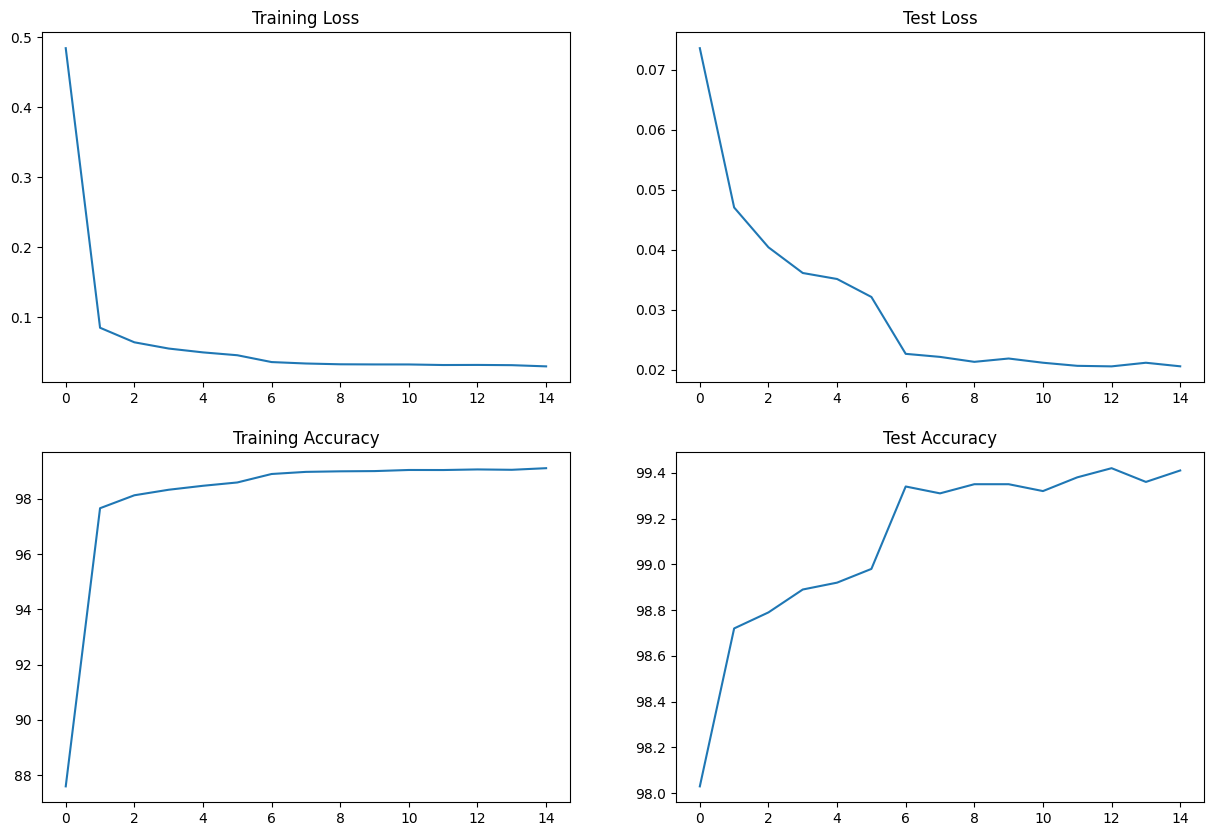

In [17]:
# plotting to be fixed in next attempt
printTrainTest_LossAcc(train_losses,train_acc,test_losses,test_acc)

1. Model is now less than 8000 parameters.
2. Max pool shifted to initial layer - after receptive field crossed 5
3. Droput reduced from 10% to 5% to keep more parameters
4. Implemented image augmentation - rotation to gain further accuracy
5. Train and test accurayc gap is less. Model is consistently above 99.35% from Epoch 9 onwards
6. Best Test accuracy : 99.43% - Epoch 13
7. Model consistently close to 99.40% accuracy in last 4 epochs - epoch # 12 to Epoch # 15


   
  